In [1]:
import numpy as np
from scipy import signal
import  matplotlib.pyplot as plt
import librosa
import librosa.display
import pandas as pd

import IPython.display as ipd

# Onset-based Segmentation with Backtracking

with librosa

- `librosa.onset.onset_detect`는 스펙트럼 노벨티 함수에서 피크를 찾는 방식으로 작동한다. 그러나 이러한 피크는 에너지의 초기 상승 또는 음의 시작을 인식하는 방식과 실제로 일치하지 않을 수 있다.

- 선택적 매개변수 `backtrack=True`는 각 피크에서 이전 로컬 최소값까지 역추적한다. 역추적은 세그먼트 시작 직후 온셋이 발생하는 세그먼트 지점을 찾는 데 유용할 수 있다. 신호의 온셋 기반 분할을 수행하기 위해 `backtrack=True`를 사용한다.

In [2]:
x, sr = librosa.load('../audio/classic_rock_beat.wav')
ipd.Audio(x, rate=sr)

In [3]:
hop_length = 512
onset_frames = librosa.onset.onset_detect(y=x, sr=sr, hop_length=hop_length)
onset_times = librosa.frames_to_time(onset_frames, sr=sr, hop_length=hop_length)
onset_samples = librosa.frames_to_samples(onset_frames, hop_length=hop_length)

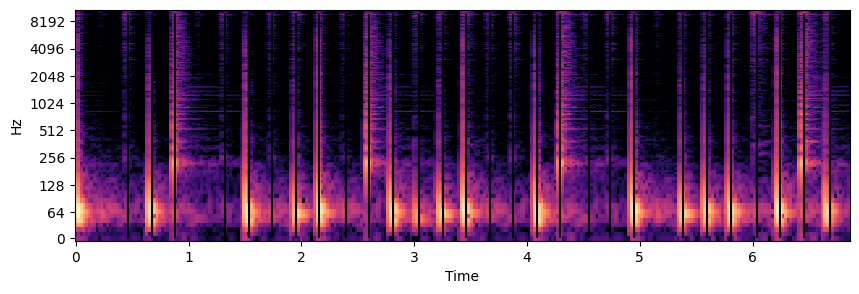

In [4]:
# Plot the onsets on top of a spectrogram of the audio:
S = librosa.stft(x)
logS = librosa.amplitude_to_db(np.abs(S))

plt.figure(figsize=(10,3))
librosa.display.specshow(logS, sr=sr, x_axis='time', y_axis='log')
plt.vlines(onset_times, 0, 10000, color='k')
plt.show()

- 스펙트로그램에서 볼 수 있듯이 감지된 온셋은 실제로 에너지가 상승하기 약간 전에 발생한다.


- 다음을 수행하는 함수를 만들 것이다.
    1. 감지된 각 온셋에서 시작하여 신호를 세그먼트로 나눈다.
    2. 각 세그먼트를 500ms의 무음으로 채운다.
    3. 패딩된 세그먼트를 연결(concatenate)한다.

In [5]:
def concatenate_segments(x, onset_samples, pad_duration=0.500):
    """Concatenate segments into one signal."""
    silence = np.zeros(int(pad_duration*sr)) # silence
    frame_sz = min(np.diff(onset_samples))   # every segment has uniform frame size
    return np.concatenate([
        np.concatenate([x[i:i+frame_sz], silence]) # pad segment with silence
        for i in onset_samples
    ])

In [6]:
concatenated_signal = concatenate_segments(x, onset_samples, 0.500)
ipd.Audio(concatenated_signal, rate=sr)

- 세그먼트 경계가 어택(attack) 전이 아니라 어택 중에 발생하기 때문에 세그먼트 사이에 작은 글리치(glitch)가 발생한다.

- 감지된 온셋에서 역추적(backtrack)하여 이 결함을 피할 수 있다.

In [7]:
onset_frames = librosa.onset.onset_detect(y=x, sr=sr, hop_length=hop_length, backtrack=True)

onset_times = librosa.frames_to_time(onset_frames, sr=sr, hop_length=hop_length)
onset_samples = librosa.frames_to_samples(onset_frames, hop_length=hop_length)

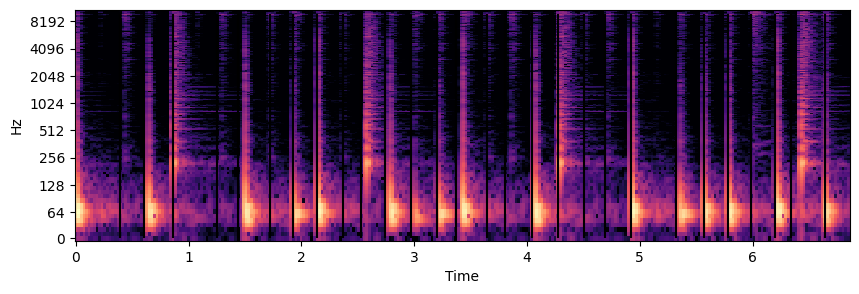

In [8]:
S = librosa.stft(x)
logS = librosa.amplitude_to_db(np.abs(S))

plt.figure(figsize=(10,3))
librosa.display.specshow(logS, sr=sr, x_axis='time', y_axis='log')
plt.vlines(onset_times, 0, 10000, color='k')
plt.show()

In [9]:
concatenated_signal = concatenate_segments(x, onset_samples, 0.500)
ipd.Audio(concatenated_signal, rate=sr)

# Evaluation

In [13]:
import mir_eval

## Evaluation: Onset detection

In [14]:
y, sr = librosa.load('../audio/simple_piano.wav')
ipd.Audio(y, rate=sr)

In [15]:
est_onsets = librosa.onset.onset_detect(y=y, sr=sr, units='time')
est_onsets

array([0.27863946, 0.510839  , 0.81269841, 1.021678  , 1.32353741,
       1.50929705, 1.83437642, 2.02013605, 2.36843537, 2.53097506,
       2.87927438, 3.0185941 , 3.36689342, 3.59909297])

In [17]:
# Load a fictional reference annotation.
ref_onsets = np.array([0, 0.270, 0.510, 1.02,
                          1.50, 2.02, 2.53, 3.01])

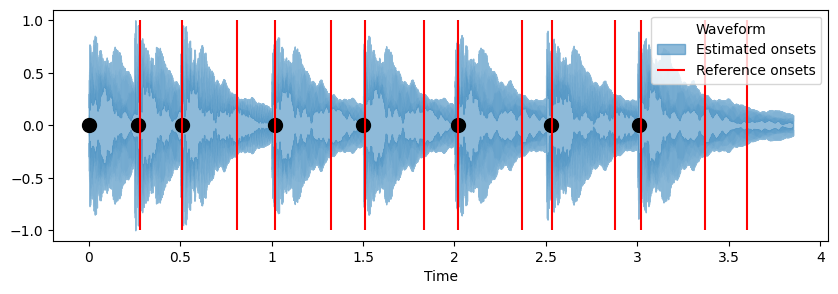

In [21]:
plt.figure(figsize=(10,3))
librosa.display.waveshow(y, sr=sr, alpha=0.5)
plt.vlines(est_onsets, -1, 1, color='r')
plt.scatter(ref_onsets, np.zeros_like(ref_onsets), color='k', s=100)
plt.legend(['Waveform', 'Estimated onsets', 'Reference onsets']);

In [22]:
# Evaluate using mir_eval.onset.evaluate
mir_eval.onset.evaluate(ref_onsets, est_onsets)

OrderedDict([('F-measure', 0.6363636363636364),
             ('Precision', 0.5),
             ('Recall', 0.875)])

In [23]:
mir_eval.onset.evaluate(ref_onsets, est_onsets, window=0.002)

OrderedDict([('F-measure', 0.36363636363636365),
             ('Precision', 0.2857142857142857),
             ('Recall', 0.5)])

## Evaluation: Beat Tracking

In [25]:
y, sr = librosa.load('../audio/prelude_cmaj.wav')

In [27]:
est_tempo, est_beats = librosa.beat.beat_track(y=y, sr=sr, bpm=120)
est_beats = librosa.frames_to_time(est_beats, sr=sr)
est_beats

array([0.55727891, 1.021678  , 1.53251701, 1.9969161 , 2.48453515,
       2.9721542 , 3.43655329, 3.90095238, 4.41179138, 4.89941043,
       5.38702948, 5.85142857, 6.33904762, 6.82666667, 7.29106576])

In [28]:
ref_beats = np.array([0, 0.50, 1.02, 1.53, 1.99, 2.48, 2.97,
       3.43, 3.90, 4.41, 4.89, 5.38,
       5.85, 6.33, 6.82, 7.29, 7.70])

[]

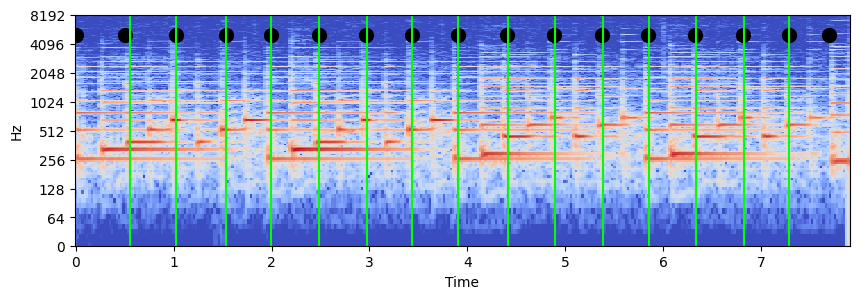

In [31]:
D = librosa.stft(y)
S = abs(D)
S_db = librosa.amplitude_to_db(S)

plt.figure(figsize=(10,3))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
plt.ylim(0, 8192)
plt.vlines(est_beats, 0, 8192, color='#00ff00')
plt.scatter(ref_beats, 5000*np.ones_like(ref_beats), color='k', s=100)
plt.plot()

In [32]:
# eval
mir_eval.beat.evaluate(ref_beats, est_beats)

OrderedDict([('F-measure', 0.9090909090909091),
             ('Cemgil', 0.8990245285127567),
             ('Cemgil Best Metric Level', 0.8990245285127567),
             ('Goto', 1.0),
             ('P-score', 0.8333333333333334),
             ('Correct Metric Level Continuous', 0.8333333333333334),
             ('Correct Metric Level Total', 0.8333333333333334),
             ('Any Metric Level Continuous', 0.8333333333333334),
             ('Any Metric Level Total', 0.8333333333333334),
             ('Information gain', 0.7276465229325831)])

In [34]:
import librosa.display
import mir_eval.display

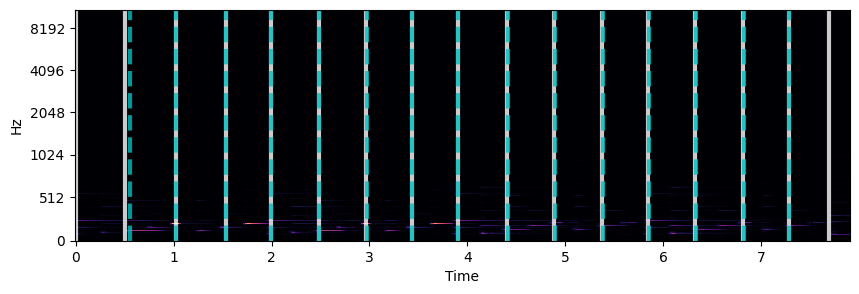

In [36]:
plt.figure(figsize=(10,3))
librosa.display.specshow(S, x_axis='time', y_axis='mel')
mir_eval.display.events(ref_beats, color='w', alpha=0.8, linewidth=3)
mir_eval.display.events(est_beats, color='c', alpha=0.8, linewidth=3, linestyle='--')
plt.show()